In [1]:
from __future__ import division
import sys
import os
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
import pandas as pd
from concurrent.futures import ProcessPoolExecutor, wait
from scipy import optimize as sco
from glob import glob
import re
from matplotlib.colors import LogNorm
from scipy.stats import norm

In [2]:
nb_dir = '/home/dup193/work/double_pulse/stat_analysis'
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
from likelihood import BinnedPoissonLikelihood
from event_selection import EventSelection, MakeDataFramesWeights
from helper_functions import build_histograms, build_error_histograms, plot_histogram, get_default_binning
from stats import sample_from_hist,ts_to_pval
from signal_injector import SignalInjector
from scan_neyman_plane import scan_neyman_plane
from limit_calculator import LimitCalculator

In [3]:
data_tc0 = np.load('/fastio2/dasha/double_pulse/data_FLUXES_NuTau_1_1.npy',mmap_mode='r')
data_tn0 = np.load('/fastio2/dasha/double_pulse/data_FLUXES_NuTau_2_1.npy',mmap_mode='r')
data_mc0 = np.load('/fastio2/dasha/double_pulse/data_FLUXES_NuMu_1_1.npy',mmap_mode='r')
data_mn0 = np.load('/fastio2/dasha/double_pulse/data_FLUXES_NuMu_2_1.npy',mmap_mode='r')
data_ec0 = np.load('/fastio2/dasha/double_pulse/data_FLUXES_NuE_1_1.npy',mmap_mode='r')
data_en0 = np.load('/fastio2/dasha/double_pulse/data_FLUXES_NuE_2_1.npy',mmap_mode='r')
data_eg0 = np.load('/fastio2/dasha/double_pulse/data_FLUXES_NuE_3_1.npy',mmap_mode='r')
data_c0 = np.load('/fastio2/dasha/double_pulse/data_MuonGun_all.npy',mmap_mode='r')

In [4]:
data_tc,data_tn,data_mc,data_mn,data_ec,data_en,data_eg,data_c = \
    EventSelection(data_tc0,data_tn0,data_mc0,data_mn0,data_ec0,data_en0,data_eg0,data_c0)
print(data_tc0.shape,data_tn0.shape,data_mc0.shape,data_mn0.shape,data_ec0.shape,data_en0.shape,data_eg0.shape,data_c0.shape)
print(data_tc.shape,data_tn.shape,data_mc.shape,data_mn.shape,data_ec.shape,data_en.shape,data_eg.shape,data_c.shape)

(128278,) (27754,) (462405,) (54601,) (420185,) (72626,) (4267,) (246367,)
(8311,) (47,) (330,) (105,) (66,) (62,) (20,) (245,)


In [6]:
secs_per_year = 31536000
years = 10
weight_name = 'weight_val_0'
wtype = 'nom'
dataframe_path = '/home/dup193/work/double_pulse/max_test/dataframes/diff_lim/'
sig_df, bkg_df = MakeDataFramesWeights(data_tc,data_tn,data_mc,data_mn,data_ec,data_en,data_eg,data_c, weight_name=weight_name, wtype=wtype,\
                                       path = dataframe_path, save= True, livetime = secs_per_year*years)

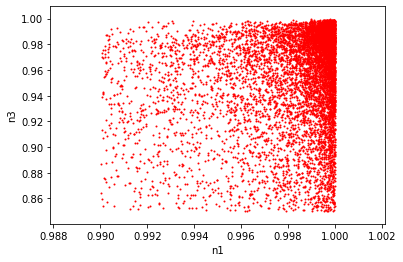

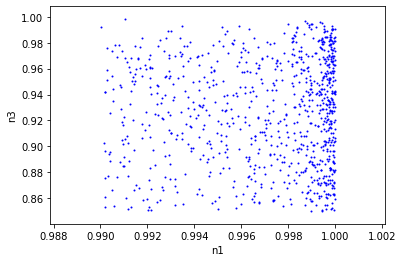

In [7]:
sig_df.plot(kind='scatter', x='n1', y='n3', s=1, c='r')
bkg_df.plot(kind='scatter', x='n1', y='n3', s=1, c='b')

In [8]:
def reweight_sig_df_to_box(sig_df, central_energy, gamma, livetime):
    ow = sig_df['OneWeight']
    en = sig_df['PrimaryNeutrinoEnergy']
    n_evts = sig_df['NEvents']
    n_files = 1000
    type_weight = 0.5
   
    def get_flux(energies, central_energy, gamma):
        # Weight to a flux of e^-gamma over 1 decade in energy
        flux_values = np.zeros_like(energies)
        log_energies = np.log10(energies)
        log_central = np.log10(central_energy)
        mask = np.logical_and(log_energies >= log_central - 0.5,
                              log_energies <= log_central + 0.5)

        norm = 1.
        flux = norm * (energies.values[mask] / central_energy)**(-gamma)
        flux_values[mask] = flux
        return flux_values

    unnormed_flux = get_flux(en, central_energy, gamma)
    unnormed_weights = unnormed_flux * ow / (type_weight * n_evts * n_files)
    weights = unnormed_weights / (np.sum(unnormed_weights) * livetime)
    sig_df = sig_df.assign(weight=weights)
    sig_df['weight'] = weights
    return (1. / (np.sum(unnormed_weights) * livetime))

In [9]:
default_base = '/home/dup193/work/double_pulse/max_test/diff_lim/'
sig_df = pd.read_csv('/home/dup193/work/double_pulse/max_test/dataframes/diff_lim/sig_out.csv')
bkg_df = pd.read_csv('/home/dup193/work/double_pulse/max_test/dataframes/diff_lim/bkg_out.csv')
livetime = secs_per_year*years
n_jobs = 20

In [ ]:
def scan_neyman_plane_for_diff_lims(sig_df, bkg_df, bins_x, bins_y, livetime, n_jobs, base_path,
        energies_to_scan=np.logspace(5, 7, 11)):
    
    for scan_energy in energies_to_scan:
        reweight_sig_df_to_box(sig_df, central_energy=scan_energy,
            gamma=1, livetime=livetime)

        sig, bkg, xe, ye = build_histograms(
            sig_df, bkg_df, bins_x, bins_y,
            density=False)

        bkg_exp = np.sum(bkg)

        mu_bins = np.linspace(0, 25, 1001)
        ts_bins = np.linspace(0, 200, 1001)
        ts_bins = ts_bins - np.diff(ts_bins)[0] / 2.
        n_samples_per_mu = 1000

        out_path = os.path.join(
            base_path,
            str(np.round(np.log10(scan_energy), 2)))

        if not os.path.isdir(out_path):
            os.makedirs(out_path)

        hists, ts_e = scan_neyman_plane(
            sig, bkg, bkg_exp,
            mu_bins, ts_bins, n_samples_per_mu,
            n_jobs=n_jobs, save=True,
            out_path=out_path)

def main(base_path, n_jobs,sig_df,bkg_df):
    
    sig_exp, bkg_exp = np.sum(sig_df['weight']), np.sum(bkg_df['weight']) 
    bins_x, bins_y = get_default_binning()
    scan_neyman_plane_for_diff_lims(sig_df, bkg_df, bins_x, bins_y, livetime, n_jobs, base_path)


if __name__ == '__main__':
    main(default_base,n_jobs,sig_df,bkg_df)

In [10]:
bins_x, bins_y = get_default_binning()
random_state = np.random.RandomState(123)

uls_flux = []
scan_energies = []

for folder in tqdm(sorted(glob('/home/dup193/work/double_pulse/max_test/diff_lim/*'))):
    scan_energy = np.power(10, float(folder.split('/')[-1]))
    scan_energies.append(scan_energy)
    mus_to_flux = reweight_sig_df_to_box(
        sig_df, central_energy=scan_energy, gamma=1,
        livetime= livetime)
    
    sig, bkg, _, _ = build_histograms(sig_df, bkg_df, bins_x, bins_y)
    likelihood = BinnedPoissonLikelihood(sig, bkg, random_state=random_state)
    #print(sig, bkg)
    lc = LimitCalculator(
        name='baseline', flux_systematic=True,
        scan_path=folder,
        df_path='/home/dup193/work/double_pulse/max_test/dataframes/diff_lim/',
        livetime=1)
    lc.sig = sig
    lc.sig_exp = np.sum(sig)
    lc.set_likelihood(likelihood)
    #print(lc.sig,lc.sig_exp)
    lc.calculate_limits(lc.acc_vals, mus_to_flux, samples=(np.zeros_like(sig)[np.newaxis]))
    
    uls_flux.append(lc.upper_limits_flux[0])
    
scan_energies = np.array(scan_energies)
uls_flux = np.array(uls_flux)

100%|██████████| 11/11 [00:21<00:00,  1.93s/it]


In [11]:
print(uls_flux * scan_energies**2)
print(uls_flux)
print(scan_energies)

[3.10903428e-10 2.39986766e-10 2.05676097e-10 1.98805267e-10
 2.07824553e-10 2.43552533e-10 3.17384893e-10 4.34538934e-10
 7.35153242e-10 1.46890466e-09 3.29726695e-09]
[3.10903428e-20 9.55404523e-21 3.25974646e-21 1.25437643e-21
 5.22031675e-22 2.43552533e-22 1.26353202e-22 6.88697799e-23
 4.63850337e-23 3.68972168e-23 3.29726695e-23]
[  100000.           158489.31924611   251188.64315096   398107.1705535
   630957.34448019  1000000.          1584893.19246111  2511886.43150958
  3981071.70553497  6309573.44480193 10000000.        ]


Text(0, 0.5, '$E^2 \\cdot \\mathrm{d}\\Phi_{E_{\\nu_{\\tau}}} / \\mathrm{d}E$ / (GeV cm$^{-2}$ sr$^{-1}$ s$^{-1}$)')

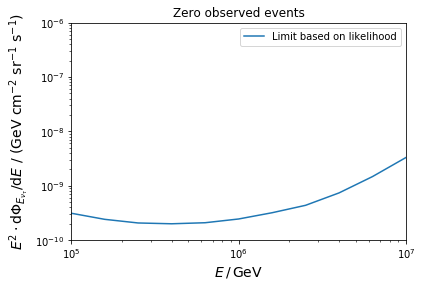

In [12]:
plt.title('Zero observed events')
plt.plot(scan_energies, uls_flux * scan_energies**2, label='Limit based on likelihood')
#plt.plot(scan_energies, differential_limits_ref * scan_energies**2, label='Limit based on counting')
plt.xscale('log')
plt.yscale('log')
plt.ylim(1e-10, 1e-6)
plt.xlim(1e5, 1e7)
plt.legend()
plt.xlabel('$E \, / \, \mathrm{GeV}$', fontsize=14)
plt.ylabel(r'$E^2 \cdot \mathrm{d}\Phi_{E_{\nu_{\tau}}} / \mathrm{d}E$ / (GeV cm$^{-2}$ sr$^{-1}$ s$^{-1}$)', fontsize=14)
#plt.savefig('differential_limits_comparison.pdf', bbox_inches='tight')